# EDA_2

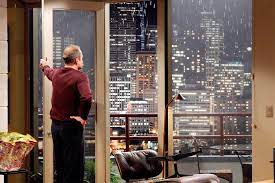

## Setting the enviromment: 

In [104]:
#1# General:
import pandas as pd  #panda library
import numpy as np   #numpy library
import missingno as msno # data cleaning
import psycopg2    
from sqlalchemy import create_engine  
import os
from dotenv import load_dotenv     
import warnings

warnings.filterwarnings("ignore")

#2# Data visualization: 
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import json
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Setting the data frame: 

In [105]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)
cur = conn.cursor()
query_string = "SELECT ks.price , kd.zipcode, kd.grade, kd.bedrooms, kd.bathrooms, kd.sqft_living, kd.sqft_lot15,kd.condition, kd.lat, kd.long, kd.waterfront  FROM eda.king_county_house_details kd FULL JOIN eda.king_county_house_sales ks ON ks.house_id  = kd.id "
df_task_01 = pd.read_sql(query_string, conn)
df_task_01.to_csv('data/eda.csv',index=False)
conn.close()


## Cleaning and organizing the data: 

In [114]:
df_task_01 = pd.read_csv('data/eda.csv')
#df_task_01.duplicated().value_counts()  --> first check on duplicates 
df_task_01 = df_task_01.drop_duplicates()
df_task_01.columns.drop_duplicates()
df_task_01.reset_index(inplace=True, drop=True)

df_task_01.fillna(0, inplace=True)  ##--> no NaNs

df_task_01.head()  ##--> final check


,price,zipcode,grade,bedrooms,bathrooms,sqft_living,sqft_lot15,condition,lat,long,waterfront
0,221900.000,98178,7,3.000,1.000,1180.000,5650.000,3,47.511,-122.257,0.000
1,538000.000,98125,7,3.000,2.250,2570.000,7639.000,3,47.721,-122.319,0.000
2,180000.000,98028,6,2.000,1.000,770.000,8062.000,3,47.738,-122.233,0.000
3,604000.000,98136,7,4.000,3.000,1960.000,5000.000,5,47.521,-122.393,0.000
4,510000.000,98074,8,3.000,2.000,1680.000,7503.000,3,47.617,-122.045,0.000


### Analyzing the possible correlations in the data frame:  

First we gonna print a combination of all plots possible considering the elements in our data frame, so we can have a overall idea of what kind of correlations we can find in it. 

In [107]:
sns.pairplot(df_task_01)


,price,zipcode,grade,bedrooms,bathrooms,sqft_living,sqft_lot15,condition,lat,long,waterfront
0,221900.000,98178,7,3.000,1.000,1180.000,5650.000,3,47.511,-122.257,0.000
1,538000.000,98125,7,3.000,2.250,2570.000,7639.000,3,47.721,-122.319,0.000
2,180000.000,98028,6,2.000,1.000,770.000,8062.000,3,47.738,-122.233,0.000
3,604000.000,98136,7,4.000,3.000,1960.000,5000.000,5,47.521,-122.393,0.000
4,510000.000,98074,8,3.000,2.000,1680.000,7503.000,3,47.617,-122.045,0.000


### #1# Price distribution:

Our data frame is a collection of houses to sell and their respective attributes. 
Considering this, a good first plot to get would it the house's price distribution in the map. However the number of rows is originally higher than the limit of data the plot can read. So, first, we'll be sorting according to the house conditions, here we'll be getting only the ones that are in really good conditions. This will give us a idea of the house/price distribution and we'll be able to take two very useful information from it.

In [108]:

houses_in_good_cond = df_task_01.query("condition > 4")
houses_in_good_cond

f = open('KCW.geojson', encoding='utf-8')
KCW = json.load(f)
background = alt.Chart(alt.Data(values=KCW)).mark_geoshape(
        fill='white',
        stroke='black',
        #color='ColorS:Q'
        ).project('albersUsa'
        ).properties(
            width=500,
            height=300)
point = alt.Chart(price_per_areas).mark_point(
    opacity=1, color='red'
    ).encode(
    latitude='lat',
    longitude='long',
    color=alt.Color('price', scale = alt.Scale(scheme= 'turbo')),#color='sqft_lots',
    #color=alt.value('red'),
    opacity=alt.value(1)
    )   

background + point

alt.LayerChart(...)

This map not only give us a idea of how expensive or cheap the houses on an certain area but also how far or concentrate they are as well.
We can assume that the area with the bigger amount of marks it's a city center.

Now let's check where the most expensive houses to sell are, assuming this could be a sign that this is a more noble region in the area.

### #A# Identifying the more noble areas

In [109]:
## Selecting every house with princes bigger than the average general price and in good conditions:
 
noble_area = houses_in_good_cond.query("price > 645000.000") 


f = open('KCW.geojson', encoding='utf-8')
KCW = json.load(f)
background_1 = alt.Chart(alt.Data(values=KCW)).mark_geoshape(
        fill='white',
        stroke='black',
        #color='ColorS:Q'
        ).project('albersUsa'
        ).properties(
            width=500,
            height=300)
point1 = alt.Chart(noble_area).mark_point(
    opacity=1, color='red'
    ).encode(
    latitude='lat',
    longitude='long',
    color=alt.Color('price', scale = alt.Scale(scheme= 'inferno')),#color='sqft_lots',
    #color=alt.value('red'),
    opacity=alt.value(1)
    )   

background_1 + point1

alt.LayerChart(...)

### #B# What could be influencing the general price: 

<Axes: xlabel='waterfront', ylabel='price'>

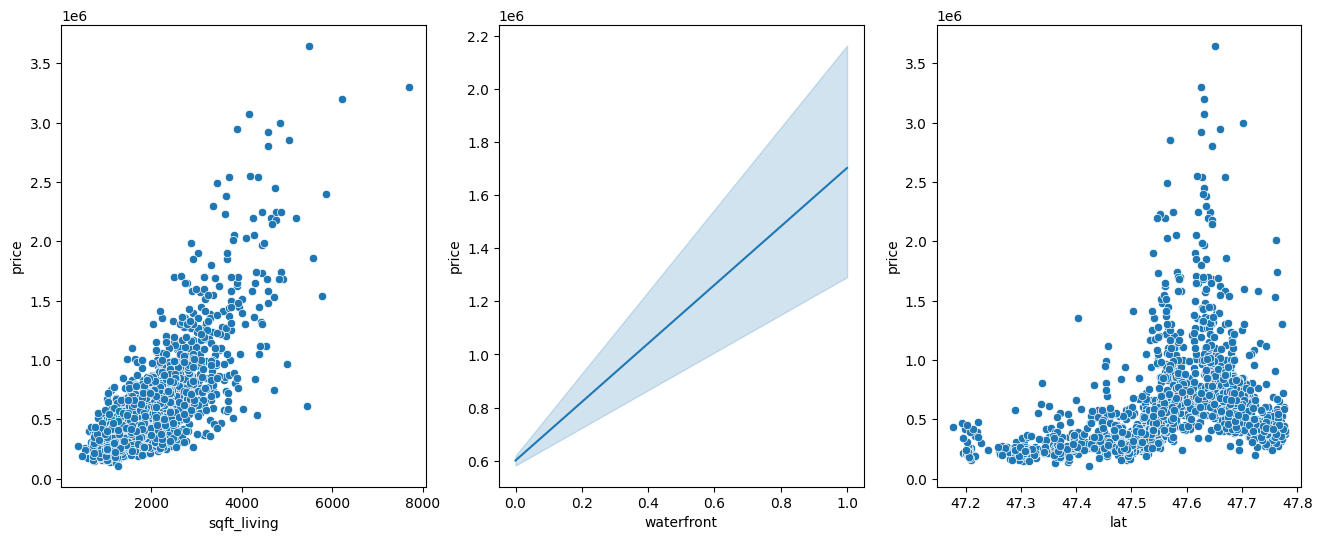

In [110]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.scatterplot(data=houses_in_good_cond, x="sqft_living",y="price", ax=ax1)
sns.scatterplot(data=houses_in_good_cond, x="lat",y="price", ax=ax3)
sns.lineplot(data=houses_in_good_cond, x="waterfront",y="price", ax=ax2)




<Axes: xlabel='grade', ylabel='waterfront'>

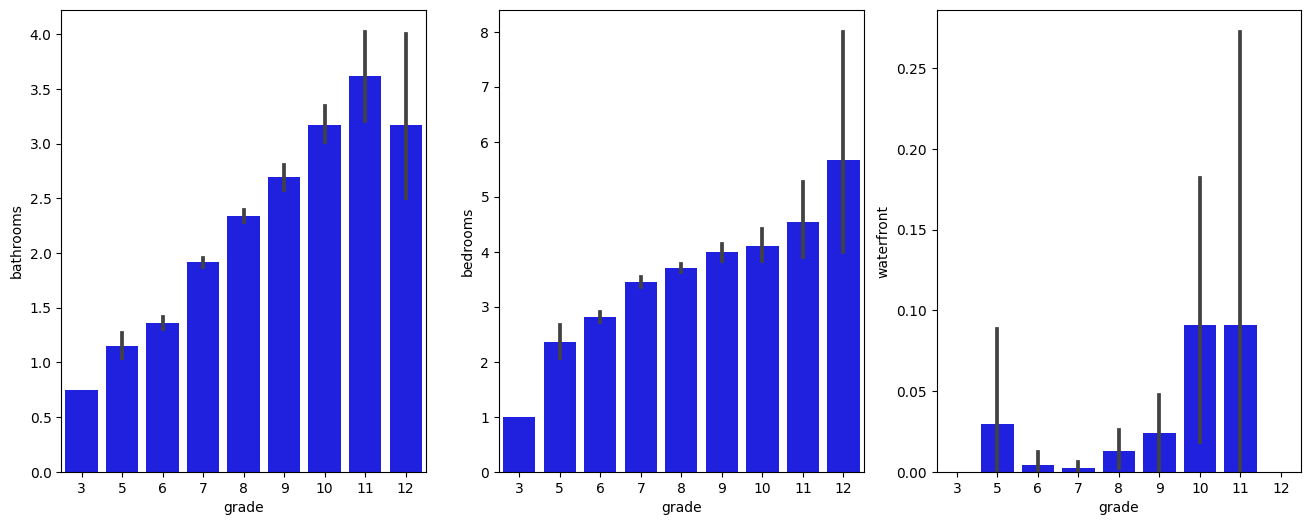

In [111]:
#B# What's influencing the grades: 

## Analysing some aspects of the house structure that can affect the price:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.barplot(data=houses_in_good_cond, x="grade",y="bathrooms", color="blue", ax=ax1)
sns.barplot(data=houses_in_good_cond, x="grade",y="bedrooms", color="blue",  ax=ax2)
sns.barplot(data=houses_in_good_cond, x="grade", y="waterfront", color="blue", ax=ax3)



<Axes: xlabel='zipcode', ylabel='sqft_living'>

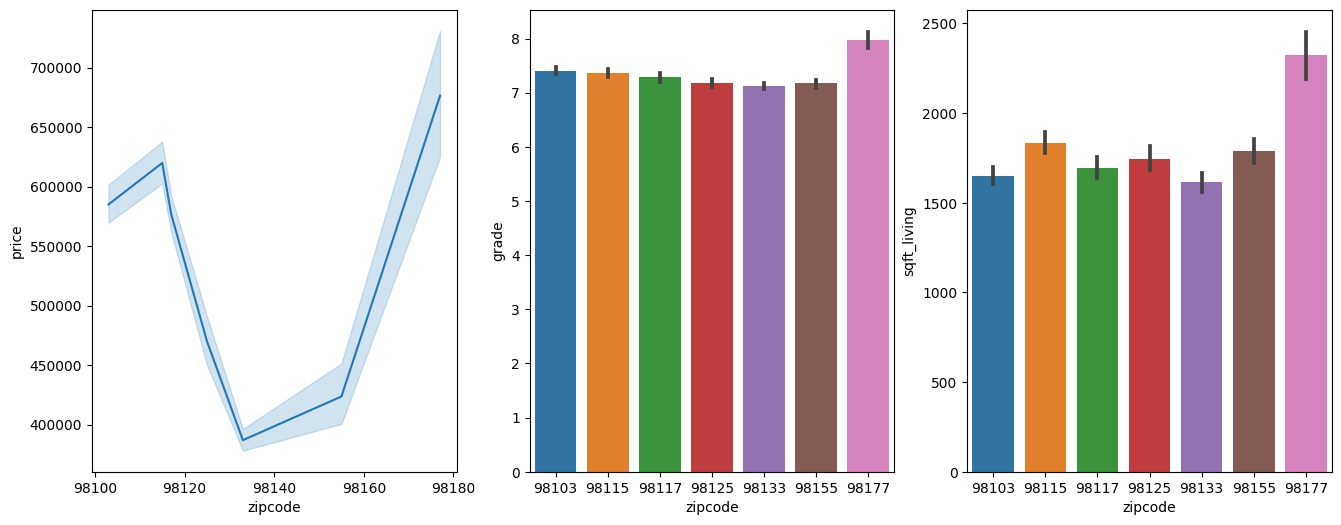

In [112]:
#2# Analysing the central areas: 

central_areas = df_task_01.query("zipcode == 98177 or zipcode == 98155 or zipcode == 98125 or zipcode == 98133 or zipcode == 98117or zipcode == 98115 or zipcode == 98103")

fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.lineplot(data=central_areas, x="zipcode",y="price", ax=ax1)
sns.barplot(data=central_areas, x="zipcode",y="grade", ax=ax2)
sns.barplot(data=central_areas, x="zipcode", y="sqft_living", ax=ax3)


<Axes: xlabel='zipcode', ylabel='sqft_living'>

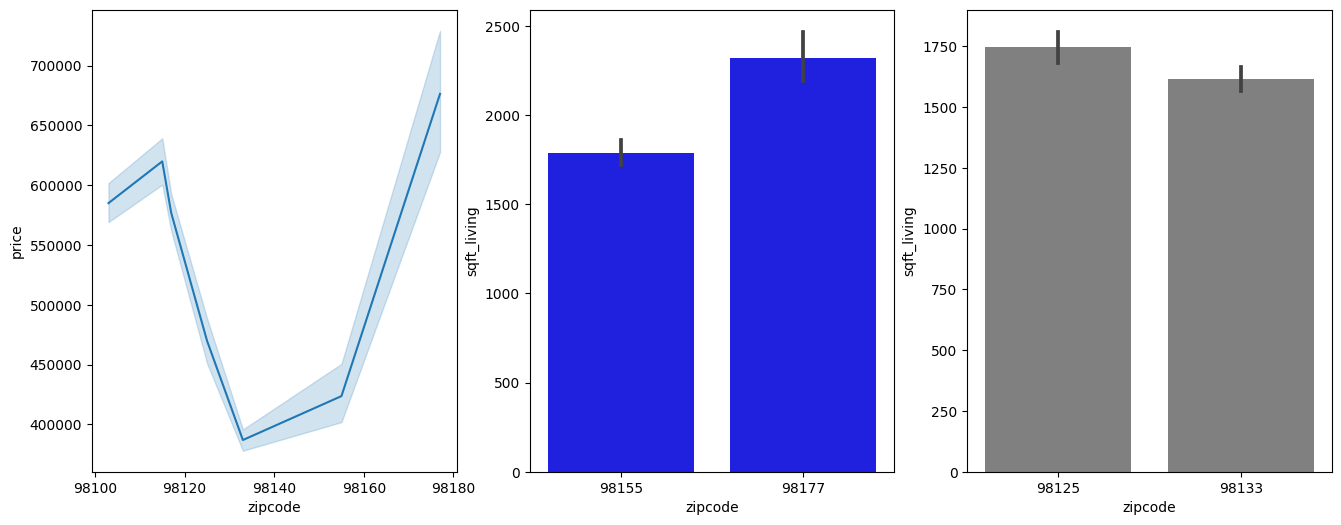

In [113]:
## Comparing the price of houses in two different central areas by their Zipcode

poor_area = central_areas.query("zipcode > 98118 and zipcode < 98140")
rich_area = central_areas.query("zipcode > 98150 and zipcode < 98190")

rich = rich_area.groupby(["zipcode"])["price"].mean().reset_index()
poor = poor_area.groupby(["zipcode"])["price"].mean().reset_index()

## Comparing the house size in those areas with the general price distribution: 

fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.lineplot(data=central_areas, x="zipcode",y="price", ax=ax1)
sns.barplot(data=rich_area, x="zipcode",y="sqft_living", color="blue", ax=ax2)
sns.barplot(data=poor_area, x="zipcode", y="sqft_living", color="gray", ax=ax3)